In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [1]:
def model_hyperparam_set(model_id,tuning_type,is_class_reg):
    #model_id=1 --RandomForestClassifier
    #model_id=2 --xgboost
    #model_id=3 --svm
    #model_id=4 --
    
    if model_id==1 and tuning_type=='Grid' and is_class_reg==1:
        param_grid = { "n_estimators"      : [100],
                       "max_depth"         : [5],
                       "max_features"      : [3, 5],                       
                       "min_samples_split" : [2] ,
                        "min_samples_leaf": [1,2,4],
                       "bootstrap": [True],
                       "criterion"         : ['entropy']}
    elif model_id==1 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = { "n_estimators"      : [50],
                       "max_depth"         : [5],
                       "max_features"      : [5],                       
                       "min_samples_split" : [2] ,
                        "min_samples_leaf": [1],
                       "bootstrap": [True],
                       "criterion"         : ['mae']}


    elif model_id==1 and tuning_type=='Random' and is_class_reg==1:
        param_grid = { "n_estimators"      : [100],
                       "max_depth": [3, None],
                       "max_features": sp_randint(1, 11),
                       "min_samples_split": sp_randint(1, 11),
                       "min_samples_leaf": sp_randint(1, 11),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}
    elif model_id==1 and tuning_type=='Random' and is_class_reg==2:
        param_grid = { "n_estimators"      : [100],
                       "max_depth": [3, None],
                       "max_features": sp_randint(1, 11),
                       "min_samples_split": sp_randint(1, 11),
                       "min_samples_leaf": sp_randint(1, 11),
                       "bootstrap": [True, False],
                       "criterion": ["mae"]}

    elif model_id==2 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = { "objective":['binary:logistic'],
                       "n_estimators": [200],
                       "learning_rate": [0.05],
                       "max_depth": [8],
                       "subsample": [0.80],
                       "colsample_bytree": [0.7]
                       #,"alpha":[10]
                         }

    elif model_id==2 and tuning_type=='Random':
            param_grid = { "n_estimators": [100,200,400],
                           "learning_rate": [0.01,0.05,0.1],
                           "max_depth": [5,None],
                           "subsample": sp_randint(0.60,0.90),
                           "colsample_bytree": sp_randint(0.60,0.90)}
    elif model_id==3 and tuning_type=='Grid' and is_class_reg==2:
        param_grid = {'num_leaves': [10],
                      'reg_alpha': [0.1],
                      'min_data_in_leaf': [10],
                      'lambda_l1': [0],
                      'lambda_l2': [0]
    }



    return param_grid        

def model_training(model,tuning_type,param_grid,traindata,target,cv_kfold,score_criterion,n_iterations):
    #target_index=traindata.columns.get_loc(target)
    x_var=list(traindata.columns)
    x_var.remove(target)

    #model = RandomForestRegressor()
    if tuning_type=='Grid':
        grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=cv_kfold,verbose=True)
    elif tuning_type=='Random':
        grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=n_iterations,cv=cv_kfold,scoring=score_criterion)   
    
    grid.fit(traindata[x_var], traindata[target])
    #print(grid)
    # summarize the results of the random parameter search
    #print(grid.best_score_)
    #print(grid.best_params_)    
    #print(grid.best_estimator_)
    return grid 


In [68]:
import statsmodels.api as sm

from sklearn import preprocessing 
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
#import sklearn
#import statsmodels.api as sm
from catboost import CatBoostRegressor as cab 
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import metrics
from sklearn.impute import SimpleImputer
from matplotlib import pyplot
import seaborn as sns


In [373]:
#model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
#model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)
jhhrTrainData=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/train_jqd04QH.csv',sep=',',header=0)
jhhrTestData=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/test_KaymcHn.csv',sep=',',header=0)


In [374]:
jhhrTestData['target']=-99999
jhhrData = jhhrTrainData.append(jhhrTestData) #merge train & test data for further processing

In [130]:
jhhrData['city'].value_counts()

city_103    7852
city_21     3022
city_16     2928
city_114    2706
city_160    1531
            ... 
city_179       6
city_31        6
city_166       6
city_139       6
city_8         6
Name: city, Length: 123, dtype: int64

In [262]:
x = jhhrTrainData.groupby(['major_discipline','gender']).agg(expCount=('gender','count'))
#jhhrTrainData.groupby(['city','target']).agg({'target':'count'})
x

expCount
major_discipline gender          
Arts             Female        34
                 Male         150
                 Other          6
Business Degree  Female        19
                 Male         218
                 Other          3
Humanities       Female       113
                 Male         447
                 Other         10
No Major         Female        12
                 Male         155
                 Other          4
Other            Female        37
                 Male         225
                 Other          7
STEM             Female       894
                 Male        9792
                 Other        109

In [279]:
jhhrData.dtypes
#jhhrData['company_size'].unique()

enrollee_id                  int64
city                      category
city_development_index     float64
education_level           category
experience                category
                            ...   
expNegCount                  int64
expTR                      float64
majDiscpPosCount             int64
majDiscpNegCount             int64
majDiscpTR                 float64
Length: 76, dtype: object

In [380]:
#jhhrData[['gender','city','education_level','company_size','company_type','experience','last_new_job']].describe()
jhhrData['city'].value_counts()


city_103    7852
city_21     3022
city_16     2928
city_114    2706
city_160    1531
            ... 
city_179       6
city_31        6
city_166       6
city_139       6
city_8         6
Name: city, Length: 123, dtype: int64

In [280]:
#missing values
jhhrData.isnull().sum()

#checking target imbalance
#jhhrTrainData[jhhrTrainData['target']==1]['target'].count()/jhhrTrainData.shape[0]
#m = jhhrData['enrolled_university'].mode().values[0]
#print(m)
#jhhrData['enrolled_university'].fillna(m, inplace=True)


enrollee_id               0
city                      0
city_development_index    0
education_level           0
experience                0
                         ..
expNegCount               0
expTR                     0
majDiscpPosCount          0
majDiscpNegCount          0
majDiscpTR                0
Length: 76, dtype: int64

In [271]:
def impute_missing(df,cols):
    
    #df[cols].apply(lambda x: x.fillna(x.mode().values[0], inplace=True))
    for x in cols:
        #mode = df[x].mode().values[0]
        mode = '99999'
        df[x].fillna(mode, inplace=True)

    return df
    

In [375]:
#start feature engineering
def feature_engg(df):
    
    label_encoder = preprocessing.LabelEncoder() 
    df['city_Le']= label_encoder.fit_transform(df['city']) 
    df['education_level_Le']= label_encoder.fit_transform(df['education_level'])
    df['major_discipline_Le']= label_encoder.fit_transform(df['major_discipline'])
    df['company_size_Le']= label_encoder.fit_transform(df['company_size'])
    df['company_type_Le']= label_encoder.fit_transform(df['company_type'])
    df['last_new_job_Le']= label_encoder.fit_transform(df['last_new_job'])
    df['experience_Le']= label_encoder.fit_transform(df['experience'])
    
    #0.79    
    conditions=[(df['city_development_index']<=0.79),(df['city_development_index']>0.79)&(df['city_development_index']<=0.91)
               ,(df['city_development_index']>0.91)&(df['city_development_index']<=0.92),(df['city_development_index']>0.92)]
    choices=[1,2,2,2]
    df['city_dev_index_bins']=np.select(conditions,choices,default=0)
    df['city_dev_index_bins'] = df['city_dev_index_bins'].astype('category')
    df=cat_to_one_hot_encode(df,['city_dev_index_bins'])
    
    conditions=[(df['training_hours']<=20),(df['training_hours']>20)&(df['training_hours']<=50)
               ,(df['training_hours']>50)&(df['training_hours']<=90),(df['training_hours']>90)&(df['training_hours']<=150)
               ,(df['training_hours']>150)]
    choices=[1,2,2,2,2]
    df['training_hours_bins']=np.select(conditions,choices,default=0)
    df['training_hours_bins'] = df['training_hours_bins'].astype('category')
    df=cat_to_one_hot_encode(df,['training_hours_bins'])

    dfAgg = df[df['target']==1].groupby('education_level').agg(eduLevelPosCount=('target','count'))
    df=pd.merge(df,dfAgg,on='education_level',how='inner')
    dfAgg = df[df['target']==0].groupby('education_level').agg(eduLevelNegCount=('target','count'))
    df=pd.merge(df,dfAgg,on='education_level',how='inner')
    df['eduLevelTR'] = df['eduLevelPosCount']/df['eduLevelNegCount']
    
    dfAgg = df.groupby('experience').agg(expCount=('experience','count'))
    df=pd.merge(df,dfAgg,on='experience',how='inner')
    #dfAgg = df[df['target']==0].groupby('experience').agg(expNegCount=('target','count'))
    #df=pd.merge(df,dfAgg,on='experience',how='inner')
    #df['expTR'] = df['expPosCount']/df['expNegCount']

    conditions=[(df['training_hours']>=150)&(df['relevent_experience']=='No relevent experience')]
    choices=[1]
    df['training_relExp_Inter']=np.select(conditions,choices,default=0)
    
    conditions=[(df['training_hours']>=150)&(df['relevent_experience']=='Has relevent experience')]
    choices=[1]
    df['training_relExpHas_Inter']=np.select(conditions,choices,default=0)

    
    df['experience'] = df['experience'].astype('category')
    conditions=[(df['experience'].isin(['<1','2','3']))&(df['enrolled_university']=='no_enrollment')
                ,(df['experience'].isin(['15','16','17','18','19','20','>20']))
                ,(df['experience'].isin(['4','5','6']))&(df['enrolled_university']=='Full time course')]
    choices=[1,2,3]
    df['experience_bins']=np.select(conditions,choices,default=0)
    df['experience_bins'] = df['experience_bins'].astype('category')
    df=cat_to_one_hot_encode(df,['experience_bins'])

    df=cat_to_one_hot_encode(df,['gender'])
    df=cat_to_one_hot_encode(df,['relevent_experience'])
    df=cat_to_one_hot_encode(df,['enrolled_university'])
    df=cat_to_one_hot_encode(df,['major_discipline'])
    df['company_size_Le'] = df['company_size_Le'].astype('category')
    df=cat_to_one_hot_encode(df,['company_size_Le'])
    df['company_type_Le'] = df['company_type_Le'].astype('category')
    df=cat_to_one_hot_encode(df,['company_type_Le'])
    
    #start creating bins & OHE on enrollee_id
    conditions=[(df['enrollee_id']>=1)&(df['enrollee_id']<8000),(df['enrollee_id']>=8000)&(df['enrollee_id']<17000)
               ,(df['enrollee_id']>=17000)&(df['enrollee_id']<25000),(df['enrollee_id']>=25000)]
    choices=[1,2,3,4]
    df['enrollee_id_bins']=np.select(conditions,choices,default=0)   
    df['enrollee_id_bins'] = df['enrollee_id_bins'].astype('category')
    df=cat_to_one_hot_encode(df,['enrollee_id_bins'])
    #end creating bins & OHE on enrollee_id
    conditions=[(df['education_level']=='Graduate')&(df['city_development_index']<=0.62)
               ,(df['education_level']=='Masters')&(df['city_development_index']<=0.70)
               ,(df['education_level']=='Primary School')&(df['city_development_index']<=0.65)]
    choices=[1,2,3]
    df['eduLevel_cityDevIndex_Inter']=np.select(conditions,choices,default=0)   
    
    dfAgg = df[df['target']==1].groupby('city').agg(cityPosCount=('target','count'))
    df=pd.merge(df,dfAgg,on='city',how='inner')
    dfAgg = df[df['target']==0].groupby('city').agg(cityNegCount=('target','count'))
    df=pd.merge(df,dfAgg,on='city',how='inner')
    df['cityTR'] = df['cityPosCount']/df['cityNegCount']

    dfAgg = df[df['target']==1].groupby('experience').agg(expPosCount=('target','count'))
    df=pd.merge(df,dfAgg,on='experience',how='inner')
    dfAgg = df[df['target']==0].groupby('experience').agg(expNegCount=('target','count'))
    df=pd.merge(df,dfAgg,on='experience',how='inner')
    df['expTR'] = df['expPosCount']/df['expNegCount']

    dfAgg = df[df['target']==1].groupby('major_discipline_Le').agg(majDiscpPosCount=('target','count'))
    df=pd.merge(df,dfAgg,on='major_discipline_Le',how='inner')
    dfAgg = df[df['target']==0].groupby('major_discipline_Le').agg(majDiscpNegCount=('target','count'))
    df=pd.merge(df,dfAgg,on='major_discipline_Le',how='inner')
    df['majDiscpTR'] = df['majDiscpPosCount']/df['majDiscpNegCount']
    
    dfAgg = df[df['target']==1].groupby('last_new_job_Le').agg(lastNewJobPosCount=('target','count'))
    df=pd.merge(df,dfAgg,on='last_new_job_Le',how='inner')
    dfAgg = df[df['target']==0].groupby('last_new_job_Le').agg(lastNewJobNegCount=('target','count'))
    df=pd.merge(df,dfAgg,on='last_new_job_Le',how='inner')
    df['lastNewJobTR'] = df['lastNewJobPosCount']/df['lastNewJobNegCount']

    df['city_Le'] = df['city_Le'].astype('category')
    df=cat_to_one_hot_encode(df,['city_Le'])
    #dfAgg = df[df['electricity_consumption']!=-99999].groupby('readTime').agg(readTimeMean=('electricity_consumption','mean'),readTimeMin=('electricity_consumption','min'),readTimeMax=('electricity_consumption','max'))
    #df=pd.merge(df,dfAgg,on='readTime',how='inner')
    #conditions=[(df['readDayOfWeek']==5),(df['readDayOfWeek']==6)]
    #choices=[1,1]
    #df['readWeekend']=np.select(conditions,choices,default=0)
    
        
    
    #conditions=[(df['temperature']<=0)]
    #choices=[1]
    #df['isTemperatureNeg']=np.select(conditions,choices,default=0)
    
    
       
    return df

def cat_to_one_hot_encode(traindata,cat_column_list):
    
    for i in range(0,len(cat_column_list)):
        if traindata[cat_column_list[i]].dtypes == 'category':        
            traindata=pd.get_dummies(traindata,columns=[cat_column_list[i]],drop_first=False)
            #cat_column_one_hot.columns=[cat_column_list[i]+'_'+str(col) for col in cat_column_one_hot.columns]
            #traindata=traindata.merge(cat_column_one_hot,left_index=True,right_index=True)
            #traindata=traindata.drop(cat_column_list[i],axis=1)
    return traindata

#end feature engineering

In [416]:
#jhhrData['roll']=jhhrData.rolling(3,on='electricity_consumption').sum()
#conditions=[(jhhrData['electricity_consumption']==-99999)]
#choices=[0]
#jhhrData['elec_cons']=np.select(conditions,choices,default=jhhrData['electricity_consumption'])

#jhhrData['roll']=jhhrData['elec_cons'].rolling(24*14).sum()

In [8]:
#EDA
jhhrData[['city_development_index','training_hours']].describe()

,city_development_index,training_hours
count,33380.000000,33380.000000
mean,0.846934,65.565638
std,0.109972,60.363572
min,0.448000,1.000000
25%,0.794000,23.000000
50%,0.910000,47.000000
75%,0.920000,89.000000
max,0.949000,336.000000


In [376]:
#jhhrData[jhhrData['electricity_consumption']==-99999].shape
#start data prep
#jhhrData.set_index(['enrollee_id'])
#jhhrData.isnull().sum()
xCatCols = ['city','gender','relevent_experience','enrolled_university','education_level','major_discipline','company_size']
xCatCols = xCatCols + ['last_new_job','experience','company_type'] 
xContCols = ['city_development_index','training_hours']

jhhrData = impute_missing(jhhrData,xCatCols)

jhhrData[xCatCols] = jhhrData[xCatCols].astype('category')

jhhrData = feature_engg(jhhrData)
#jhhrData[jhhrData['target']!=-99999]['target'].describe()

#jhhrData=jhhrData.drop(['Date'],axis=1)
#end data prep



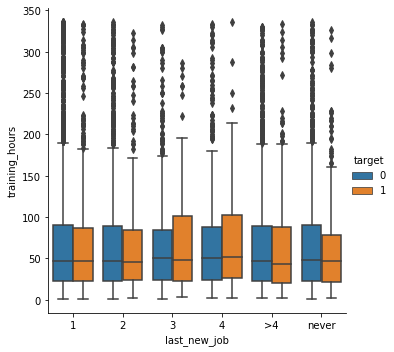

In [112]:
sns.catplot(x="last_new_job", y="training_hours",hue="target", kind="box", data=jhhrTrainData);

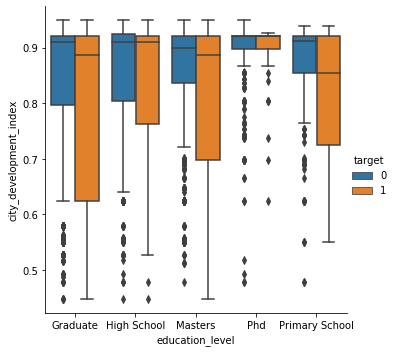

In [76]:
sns.catplot(x="education_level", y="city_development_index",hue='target', kind="box", data=jhhrTrainData);

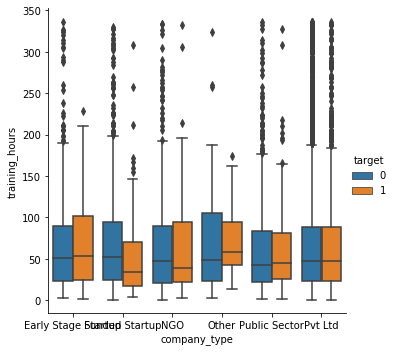

In [119]:
sns.catplot(x="company_type", y="training_hours",hue='target', kind="box", data=jhhrTrainData);

In [377]:
#jhhrData['company_size_Le'].value_counts()
jhhrData.head(5)
jhhrData.columns
#jhhrData.sort_values(by=['enrollee_id'])
#jhhrData[jhhrData['target']!=-99999].groupby(['company_size','target']).agg({'target':['count']})

Index(['enrollee_id', 'city', 'city_development_index', 'education_level',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target',
       ...
       'city_Le_113', 'city_Le_114', 'city_Le_115', 'city_Le_116',
       'city_Le_117', 'city_Le_118', 'city_Le_119', 'city_Le_120',
       'city_Le_121', 'city_Le_122'],
      dtype='object', length=201)

In [31]:
jhhrData['enrollee_id'].describe()
#jhhrTestData['enrollee_id'].describe()

count    33380.000000
mean     16690.500000
std       9636.120329
min          1.000000
25%       8345.750000
50%      16690.500000
75%      25035.250000
max      33380.000000
Name: enrollee_id, dtype: float64

In [398]:
X_cols = ['city_development_index','training_hours'
          #, 'city_Le',
       ,'education_level_Le', 'major_discipline_Le',# 'company_size_Le',
       #'company_type_Le',
       'last_new_job_Le',#'experience_Le',
       'gender_Female', 'gender_Male',
       'gender_Other','gender_99999', 'relevent_experience_Has relevent experience',
       'relevent_experience_No relevent experience',
       'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment','enrolled_university_99999']

X_cols = X_cols +['city_dev_index_bins_1','city_dev_index_bins_2']
                  #,'city_dev_index_bins_3','city_dev_index_bins_4']
X_cols = X_cols + ['eduLevelTR','expCount']
X_cols = X_cols + ['major_discipline_Arts','major_discipline_Business Degree','major_discipline_Humanities'
                   ,'major_discipline_No Major','major_discipline_Other','major_discipline_99999']
X_cols = X_cols + ['company_size_Le_0','company_size_Le_1','company_size_Le_2','company_size_Le_3'
                   ,'company_size_Le_4','company_size_Le_5','company_size_Le_6','company_size_Le_7','company_size_Le_8']

#X_cols = X_cols + ['training_hours_bins_1','training_hours_bins_2']
#                   ,'training_hours_bins_5']
X_cols = X_cols + ['company_type_Le_0','company_type_Le_1','company_type_Le_2','company_type_Le_3'
                   ,'company_type_Le_4','company_type_Le_5','company_type_Le_6']

X_cols = X_cols +['training_relExp_Inter','training_relExpHas_Inter']
X_cols = X_cols +['experience_bins_'+str(x) for x in range(4)]
X_cols = X_cols +['enrollee_id']
#X_cols = X_cols +['enrollee_id_bins_'+str(x) for x in range(1,5)]
X_cols = X_cols +['eduLevel_cityDevIndex_Inter','cityTR','expTR','majDiscpTR','lastNewJobTR']
#X_cols = X_cols +['city_Le_'+str(x) for x in range(123)]

X_cols = X_cols +['target']
X_cols1=[x for x in X_cols if x!='target']
jhhrTrainData=jhhrData[jhhrData['target']!=-99999]
jhhrTestData=jhhrData[jhhrData['target']==-99999]
jhhrTrainData[X_cols].head(20)

,city_development_index,training_hours,education_level_Le,major_discipline_Le,last_new_job_Le,gender_Female,gender_Male,gender_Other,gender_99999,relevent_experience_Has relevent experience,...,experience_bins_1,experience_bins_2,experience_bins_3,enrollee_id,eduLevel_cityDevIndex_Inter,cityTR,expTR,majDiscpTR,lastNewJobTR,target
0,0.689,106,1,6,0,0,1,0,0,1,...,1,0,0,23798,0,0.141304,0.197314,0.15825,0.155444,0
1,0.689,68,1,6,0,0,1,0,0,1,...,1,0,0,32506,0,0.141304,0.197314,0.15825,0.155444,1
2,0.689,35,1,6,0,0,0,0,1,1,...,1,0,0,5907,0,0.141304,0.197314,0.15825,0.155444,0
3,0.689,72,1,6,0,1,0,0,0,0,...,1,0,0,23971,0,0.141304,0.197314,0.15825,0.155444,0
4,0.920,4,1,6,0,0,1,0,0,1,...,1,0,0,20247,0,0.148353,0.197314,0.15825,0.155444,0
5,0.920,112,1,6,0,1,0,0,0,1,...,1,0,0,17726,0,0.148353,0.197314,0.15825,0.155444,0
6,0.920,8,1,6,0,0,1,0,0,0,...,0,0,0,26047,0,0.148353,0.197314,0.15825,0.155444,0
7,0.920,25,1,6,0,1,0,0,0,1,...,1,0,0,8984,0,0.148353,0.197314,0.15825,0.155444,0
8,0.920,11,1,6,0,0,1,0,0,0,...,0,0,0,3483,0,0.148353,0.197314,0.15825,0.155444,0
9,0.920,14,1,6,0,1,0,0,0,1,...,1,0,0,31151,0,0.148353,0.197314,0.15825,0.155444,0


In [385]:
jhhrData.columns
print(len(X_cols1))
#jhhrTrainData['target'].value_counts()
print((X_cols1))

176
['city_development_index', 'training_hours', 'education_level_Le', 'major_discipline_Le', 'last_new_job_Le', 'gender_Female', 'gender_Male', 'gender_Other', 'gender_99999', 'relevent_experience_Has relevent experience', 'relevent_experience_No relevent experience', 'enrolled_university_Full time course', 'enrolled_university_Part time course', 'enrolled_university_no_enrollment', 'enrolled_university_99999', 'city_dev_index_bins_1', 'city_dev_index_bins_2', 'eduLevelTR', 'expCount', 'major_discipline_Arts', 'major_discipline_Business Degree', 'major_discipline_Humanities', 'major_discipline_No Major', 'major_discipline_Other', 'major_discipline_99999', 'company_size_Le_0', 'company_size_Le_1', 'company_size_Le_2', 'company_size_Le_3', 'company_size_Le_4', 'company_size_Le_5', 'company_size_Le_6', 'company_size_Le_7', 'company_size_Le_8', 'company_type_Le_0', 'company_type_Le_1', 'company_type_Le_2', 'company_type_Le_3', 'company_type_Le_4', 'company_type_Le_5', 'company_type_Le_6',

In [328]:
jhhrTrainData[X_cols1]

,city_development_index,training_hours,city_Le,education_level_Le,major_discipline_Le,last_new_job_Le,gender_Female,gender_Male,gender_Other,gender_99999,...,experience_bins_0,experience_bins_1,experience_bins_2,experience_bins_3,enrollee_id,eduLevel_cityDevIndex_Inter,cityTR,expTR,majDiscpTR,lastNewJobTR
0,0.689,106,41,1,6,0,0,1,0,0,...,0,1,0,0,23798,0,0.141304,0.197314,0.158250,0.155444
1,0.689,68,41,1,6,0,0,1,0,0,...,0,1,0,0,32506,0,0.141304,0.197314,0.158250,0.155444
2,0.689,35,41,1,6,0,0,0,0,1,...,0,1,0,0,5907,0,0.141304,0.197314,0.158250,0.155444
3,0.689,72,41,1,6,0,1,0,0,0,...,0,1,0,0,23971,0,0.141304,0.197314,0.158250,0.155444
4,0.920,4,5,1,6,0,0,1,0,0,...,0,1,0,0,20247,0,0.148353,0.197314,0.158250,0.155444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33370,0.910,59,48,1,1,3,0,1,0,0,...,1,0,0,0,27103,0,0.102667,0.116854,0.116822,0.164983
33372,0.910,26,48,1,1,3,0,1,0,0,...,1,0,0,0,20036,0,0.102667,0.171393,0.116822,0.164983
33375,0.920,20,5,1,1,3,0,1,0,0,...,0,0,1,0,5044,0,0.148353,0.100000,0.116822,0.164983
33376,0.920,206,5,1,1,3,0,1,0,0,...,0,0,1,0,30921,0,0.148353,0.100000,0.116822,0.164983


In [400]:
#xgboost cross validation
#iter = 32 is best as of now
params = {
    'max_depth':8,
    'min_child_weight': 1,
    'eta':0.03,
    'subsample': 0.80,
    'colsample_bytree': 0.50,
    'objective':'binary:logistic',
    'eval_metric': 'auc',
    'num_boost_round': 70,
    'gamma':0
    
}
d_train = xgb.DMatrix(jhhrTrainData[X_cols1], label=jhhrTrainData['target'])

cv_results = xgb.cv(
    params,
    d_train,
    num_boost_round=70,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=300
)
cv_results
#model training




,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.659820,0.001947,0.634064,0.009070
1,0.691263,0.005771,0.648454,0.013545
2,0.706886,0.004257,0.652904,0.012520
3,0.715326,0.006178,0.658028,0.007449
4,0.724461,0.002640,0.659546,0.007362
...,...,...,...,...
65,0.821805,0.004724,0.674054,0.007997
66,0.822638,0.004423,0.674250,0.007983
67,0.823474,0.004815,0.674569,0.008309
68,0.824112,0.004844,0.674612,0.008329


 XGBoost Train AUC: 0.7891699911619967
[0.01752063 0.0072761  0.00655356 0.01158892 0.00864584 0.0075753
 0.00545058 0.00588046 0.00617289 0.00971908 0.0116966  0.00868636
 0.00760688 0.00851974 0.00593933 0.03613571 0.00829949 0.01176455
 0.00767445 0.00535329 0.00420971 0.00662111 0.0081157  0.00520054
 0.01383977 0.00851211 0.00584442 0.00610581 0.00782658 0.00716919
 0.0066002  0.00764587 0.05749885 0.00802764 0.02639137 0.00567697
 0.00804711 0.00886621 0.00704429 0.00689933 0.00665177 0.0060716
 0.00730442 0.00647174 0.00719569 0.0099323  0.00622644 0.00803261
 0.00643373 0.02542953 0.00977386 0.00840647 0.01003617 0.
 0.0020723  0.00763024 0.00560786 0.0056185  0.01249225 0.00204774
 0.00573236 0.         0.         0.         0.00429209 0.
 0.00434014 0.00611141 0.00472421 0.00695799 0.00332561 0.
 0.         0.         0.00576675 0.00924702 0.         0.00452155
 0.         0.00793319 0.         0.         0.00746639 0.00498383
 0.00585822 0.         0.00445827 0.         0.00

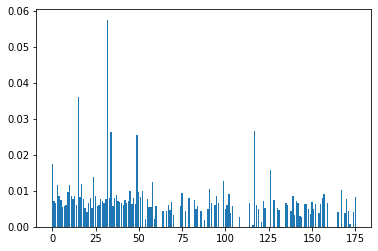

In [394]:
xgb_model=xgb.XGBClassifier(learning_rate =0.03, n_estimators=50, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.5,
 objective= 'binary:logistic',eval_metric='auc', nthread=4, scale_pos_weight=1, seed=42)
xgb_model.fit(jhhrTrainData[X_cols1],jhhrTrainData['target'])

pred = xgb_model.predict_proba(jhhrTrainData[X_cols1])
fpr, tpr, thresholds = metrics.roc_curve(jhhrTrainData['target'], pred[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)

print(' XGBoost Train AUC: {}'.format(auc))
print(xgb_model.feature_importances_)
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()
#xgb.plot_importance(xgb_model)

In [173]:
pred[:,1]

array([0.2511915 , 0.2912449 , 0.28796837, ..., 0.34060544, 0.2881501 ,
       0.36035523], dtype=float32)

In [401]:
categoricals = [x for x in X_cols1 if x not in ['city_development_index','training_hours']]
indexes_of_categories = [jhhrTrainData.columns.get_loc(col) for col in categoricals]

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=jhhrTrainData[X_cols1], y=jhhrTrainData['target'])

param_grid = {
    'num_leaves': [30],
    'reg_alpha': [0],
    'min_data_in_leaf': [10],
    'lambda_l1': [0],
    'lambda_l2': [0],
    'learning_rate': [0.02]
    }

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.05 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
#params['metric'] = 'binary_error'          # or 'mae'
params['sub_feature'] = 0.70      # feature_fraction 
params['bagging_fraction'] = 0.80 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 50         # min_data_in_leaf
#params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

#cross validation
d_train = lgbm.Dataset(jhhrTrainData[X_cols1], label=jhhrTrainData['target'])

cv_results = lgbm.cv(param_grid,d_train, num_boost_round=87, nfold=5, 
                    verbose_eval=1, early_stopping_rounds=300,metrics='auc')
#



[1]	cv_agg's auc: 0.654032 + 0.00871482
[2]	cv_agg's auc: 0.654213 + 0.00879765
[3]	cv_agg's auc: 0.654641 + 0.00937397
[4]	cv_agg's auc: 0.656258 + 0.00968047
[5]	cv_agg's auc: 0.657753 + 0.00921683
[6]	cv_agg's auc: 0.659343 + 0.00822189
[7]	cv_agg's auc: 0.660525 + 0.00927995
[8]	cv_agg's auc: 0.660803 + 0.00860788
[9]	cv_agg's auc: 0.662048 + 0.00977738
[10]	cv_agg's auc: 0.663816 + 0.0107577
[11]	cv_agg's auc: 0.664124 + 0.0103713
[12]	cv_agg's auc: 0.663935 + 0.0103976
[13]	cv_agg's auc: 0.664734 + 0.0104415
[14]	cv_agg's auc: 0.665053 + 0.010854
[15]	cv_agg's auc: 0.665817 + 0.0112751
[16]	cv_agg's auc: 0.66638 + 0.0106126
[17]	cv_agg's auc: 0.666998 + 0.011147
[18]	cv_agg's auc: 0.667101 + 0.0109366
[19]	cv_agg's auc: 0.667605 + 0.0106281
[20]	cv_agg's auc: 0.668053 + 0.0104517
[21]	cv_agg's auc: 0.668484 + 0.0106467
[22]	cv_agg's auc: 0.668523 + 0.01074
[23]	cv_agg's auc: 0.668708 + 0.0106971
[24]	cv_agg's auc: 0.669364 + 0.0102411
[25]	cv_agg's auc: 0.669175 + 0.0103552
[26]	

In [342]:
#LightGBM model training
lgb_model = lgbm.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=87, learning_rate=0.02, metric='auc',categorical_feature=indexes_of_categories)
lgb_model.fit(jhhrTrainData[X_cols1],jhhrTrainData['target'])

pred = lgb_model.predict_proba(jhhrTrainData[X_cols1])
fpr, tpr, thresholds = metrics.roc_curve(jhhrTrainData['target'], pred[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)

#lgb_model.
print('LightGBM Train AUC: {}'.format(auc))


C:\Users\Mithilesh\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mithilesh\anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LightGBM Train AUC: 0.7256213323257406


In [395]:
jhhrTestData.columns
jhhrTestData['target']=xgb_model.predict_proba(jhhrTestData[X_cols1])[:,1]
#jhhrTestData['target']=lgb_model.predict_proba(jhhrTestData[X_cols1])[:,1]

C:\Users\Mithilesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [396]:
jhhrTestData.shape
#jhhrTestData[jhhrTestData['target']<=200]
jhhrTestData['target'].head(10)

74    0.349870
75    0.174241
76    0.175124
77    0.182871
78    0.225339
79    0.169250
80    0.170724
81    0.257380
82    0.277155
83    0.238230
Name: target, dtype: float32

In [397]:
jhhrTestData[['enrollee_id','target']].to_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submission.csv',index=False)

In [404]:
#ensemble multiple predictions
jhhrTestPred6823=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submissions/Submission_0.6823.csv',sep=',',header=0)
jhhrTestPred67=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submissions/Submission_lgbm_0.67.csv',sep=',',header=0)
#jhhrTestPred8153=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack Forecasting/Submissions/Submission_81.53.csv',sep=',',header=0)
#jhhrTestPred8346=pd.read_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack Forecasting/Submissions/Submission_83.46.csv',sep=',',header=0)

jhhrTestPred6823.rename(columns={"target": "target_1"},inplace=True)
jhhrTestPred67.rename(columns={"target": "target_2"},inplace=True)
#jhhrTestPred8153.rename(columns={"electricity_consumption": "electricity_consumption_3"},inplace=True)
#jhhrTestPred8346.rename(columns={"electricity_consumption": "electricity_consumption_4"},inplace=True)

#jhhrTestPred8346.head(5)

In [406]:
jhhrTestEnsem = pd.merge(jhhrTestPred6823,jhhrTestPred67,on='enrollee_id',how='inner')
#jhhrTestEnsem = pd.merge(jhhrTestPred67,jhhrTestPred8153,on='enrollee_id',how='inner')
#jhhrTestEnsem = pd.merge(jhhrTestEnsem,jhhrTestPred8346,on='ID',how='inner')
jhhrTestEnsem['target'] = jhhrTestEnsem['target_1']*0.7+jhhrTestEnsem['target_2']*0.3

In [407]:
jhhrTestEnsem

,enrollee_id,target_1,target_2,target
0,31400,0.207765,0.179097,0.199164
1,18117,0.188947,0.133684,0.172368
2,11061,0.365009,0.308032,0.347916
3,32618,0.139878,0.082669,0.122715
4,26231,0.138663,0.082510,0.121818
...,...,...,...,...
15016,29355,0.133997,0.086336,0.119699
15017,20869,0.243425,0.196199,0.229257
15018,29111,0.154931,0.078745,0.132076
15019,30838,0.206298,0.110339,0.177511


In [565]:
jhhrTestEnsem[['enrollee_id','target']].to_csv('E:/Data Science/Analytics Vidhya/Hackathon/Janatahack HR Analytics/Submission.csv',index=False)